In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1、获取数据
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set(style="darkgrid")

data_store = pd.read_csv('../data/store.csv',low_memory=False)
data_test = pd.read_csv('../data/test.csv',low_memory=False)
data_train = pd.read_csv('../data/train.csv',low_memory=False)

# 增加客单价、Store分类、人流量 等商店参数
data_train_count = data_train
data_train_count['count'] = 1
data_train_count = data_train_count.groupby("Store").sum()
data_train_count["salesPerCustomer"] = data_train_count["Sales"]/data_train_count["Customers"]
data_train_count["salesPerCount"] = data_train_count["Sales"]/data_train_count["count"]
data_train_count["customerPerCount"] = data_train_count["Customers"]/data_train_count["count"]
data_train_count = data_train_count.reset_index()

# 将两个表合为一个
data_feature_all = data_test.append(data_train)
data_test["from"]=1
data_train["from"]=0
data_customer_entire=data_train.append(data_test)

# 将商店数据merge进去
data_train_count_real = data_train_count.loc[:,["Store","salesPerCustomer","salesPerCount","customerPerCount"]]
data_store_all = pd.merge(data_store,data_train_count_real,on="Store")
data_feature_all = pd.merge(data_customer_entire,data_store_all,on="Store")
data_feature_all["Date"] = pd.to_datetime(data_feature_all["Date"], format="%Y-%m-%d", errors='ignore')

def insertOneHot(x,strCol,arrValues):
    for val in arrValues:
        newCol = strCol+"_"+val
        x[newCol]= 0
        x.loc[x[strCol]==val,newCol] = 1
    return x

# 处理 【Date】 字段
data_feature_all["Date"] = pd.to_datetime(data_feature_all["Date"], format="%Y-%m-%d", errors='ignore')
data_feature_all["date_year"] = data_feature_all["Date"].dt.year
data_feature_all["date_month"] = data_feature_all["Date"].dt.month
data_feature_all["date_day"] = data_feature_all["Date"].dt.day
data_feature_all['DayOfYear'] = data_feature_all["Date"].dt.dayofyear
data_feature_all['WeekOfYear'] = data_feature_all["Date"].dt.weekofyear
# data_feature_all = data_feature_all.set_index("Date")

# 竞争对手开业月数
data_feature_all["CompetitionForMonths"] = (data_feature_all["date_year"] - data_feature_all["CompetitionOpenSinceYear"])*12 \
    +(data_feature_all["date_month"]-data_feature_all["CompetitionOpenSinceMonth"])

# promo持续天数
data_feature_all["Promo2LastDays"] = (data_feature_all["date_year"]-data_feature_all["Promo2SinceYear"])*365 \
    +(data_feature_all["DayOfYear"]-7*(data_feature_all["Promo2SinceWeek"]))

#所有的训练数据
data_train_all=data_feature_all[data_feature_all["from"]==0]

plt.rcParams["figure.figsize"] = (18,9)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


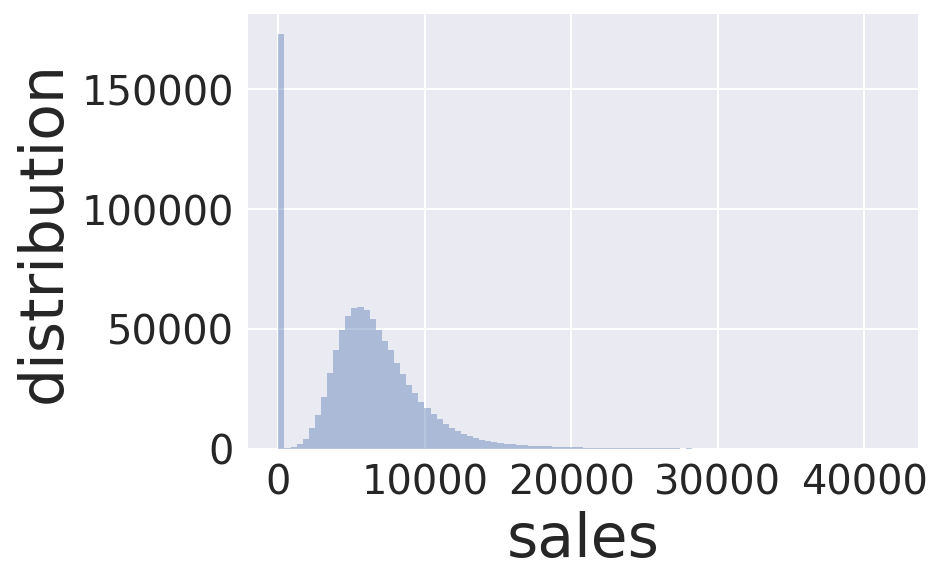

In [2]:
# 绘制sales分布图
_ = sns.distplot(data_train["Sales"], hist=True, kde=False, bins=100)
plt.xlabel('sales', fontsize=30)
plt.ylabel('distribution', fontsize=30)
plt.show()

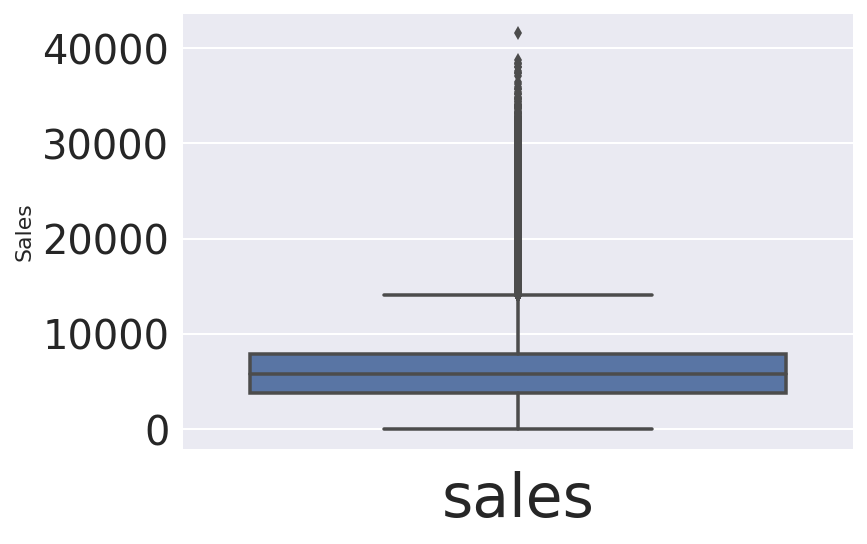

In [3]:
ax = sns.boxplot(y="Sales", data=data_train_all)
plt.xlabel('sales', fontsize=30)
plt.show()

**结论：**

1、除开高达150000+条销量为0的记录外，其余数据还是比较服从期望销量为5000左右的近似正态分布。

2、是一个长尾分布，越接近于最大值，分布越系稀疏，超过40000之后的分布就很少了，可能存在离群值需要处理。

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


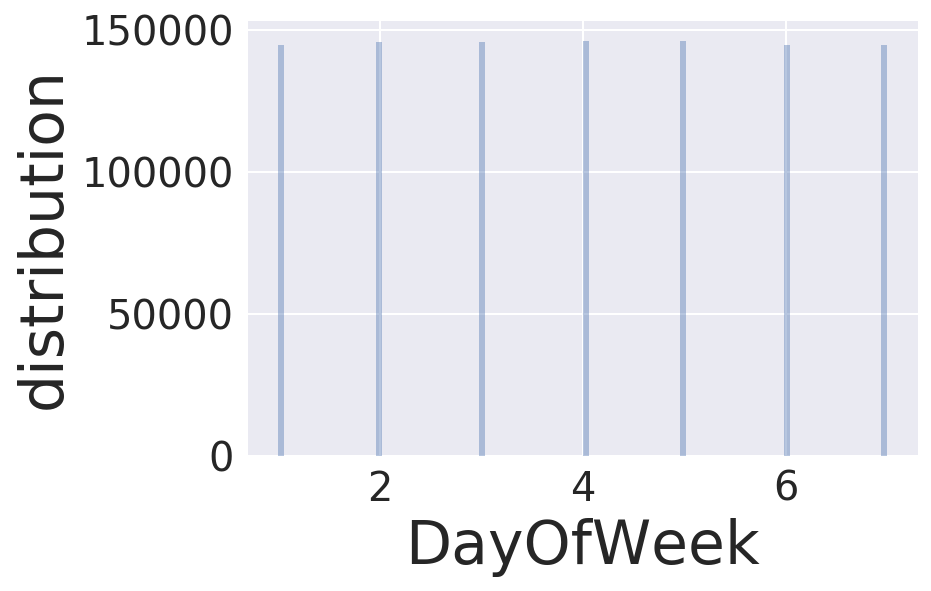

In [4]:
_ = sns.distplot(data_train["DayOfWeek"],hist=True,kde=False,bins=100)
plt.xlabel("DayOfWeek",fontsize=30)
plt.ylabel("distribution",fontsize=30)
plt.show()

注意，1-7分别代表的是周日开始到周六结束的分布情况。

**结论：**

1、一周内每天的数据都比较接近，不大可能出现因为采样的偏差导致最终对于某些天预测不准确的情况。

2、数据量都超过了140000万条，足够我们开展训练了。


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


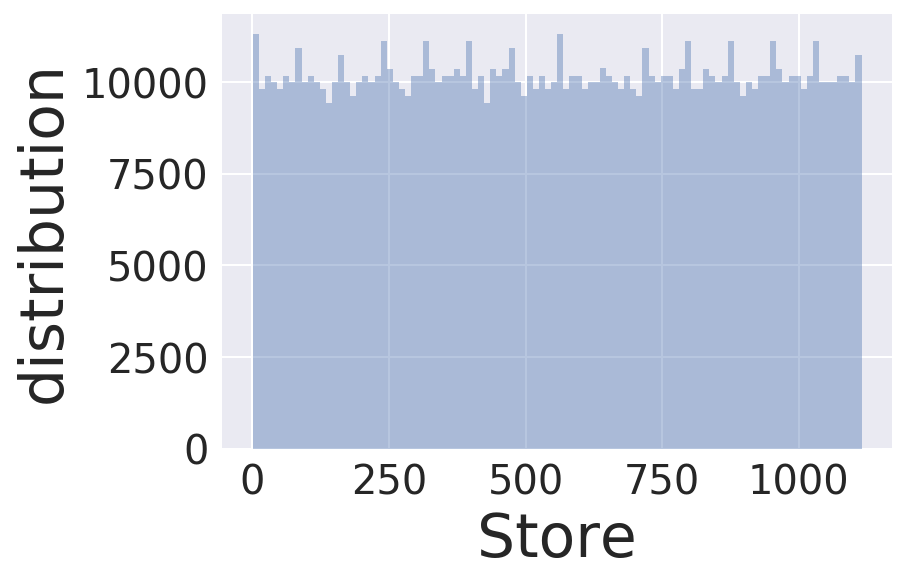

In [5]:
_ = sns.distplot(data_train["Store"],hist=True,kde=False,bins=100)
plt.xlabel("Store",fontsize=30)
plt.ylabel("distribution",fontsize=30)
plt.show()

**结论：**

1、对于1115家商店来说，采样分布均匀。

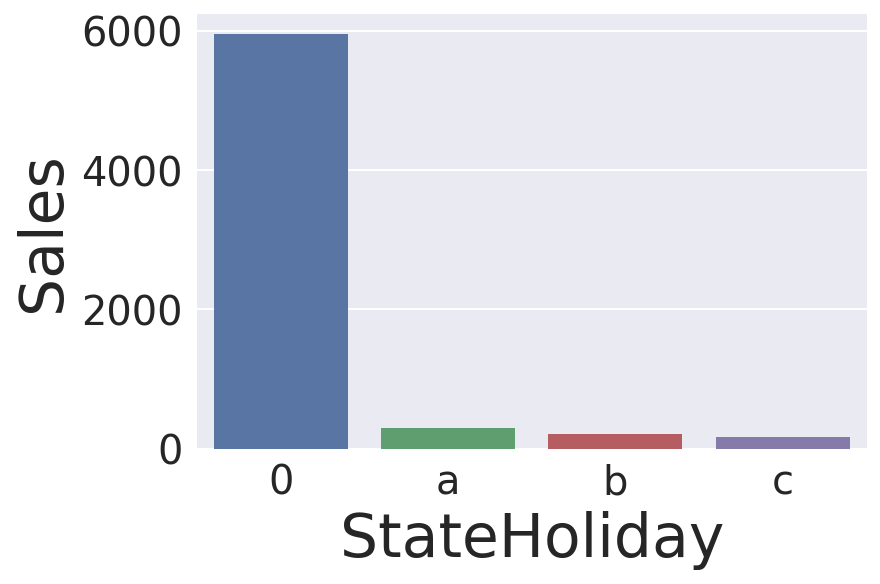

In [6]:
ax = sns.barplot(x="StateHoliday", y="Sales",data=data_train,ci=0)
plt.xlabel('StateHoliday', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

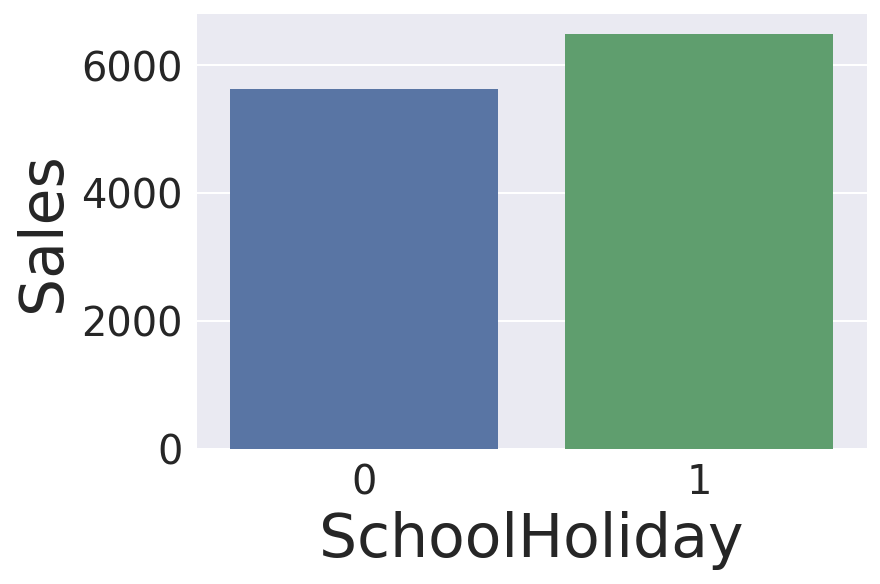

In [7]:
ax = sns.barplot(x="SchoolHoliday", y="Sales",data=data_train,ci=0)
plt.xlabel('SchoolHoliday', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

**结论**

1、对于法定假日，无论是什么类型的假日，销量都会明显低于非节假日。

2、对于学校假日和非学校假日，前者的销量要比后者高很多，这也印证了之前的判断，即学校放假=》学生需要人陪=》家长带去逛街=》销量增加。

In [ ]:
ax = sns.regplot(x="Sales", y="Customers", data=data_train)
plt.xlabel('Sales', fontsize=30)
plt.ylabel('Customers', fontsize=30)
plt.show()

In [ ]:
ax = sns.barplot(x="Assortment", y="Sales",data=data_train_all,ci=0)
plt.xlabel('Assortment', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
ax = sns.barplot(x="StoreType", y="Sales",data=data_train_all,ci=0)
plt.xlabel('StoreType', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
ax = sns.barplot(x="Promo", y="Sales",data=data_train_all,ci=0)
plt.xlabel('Promo', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
ax = sns.barplot(x="Promo2", y="Sales",data=data_train_all,ci=0)
plt.xlabel('Promo2', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
ax = sns.stripplot(x="CompetitionDistance", y="Sales", data=data_train_all)
sns.despine(left=True, bottom=False, right=False, top=False)
plt.xlabel('CompetitionDistance', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
ax = sns.barplot(x="WeekOfYear", y="Sales",data=data_train_all,ci=0)
sns.despine(left=True, bottom=False, right=False, top=False)
plt.xlabel('WeekOfYear', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
ax = sns.barplot(x="CompetitionForMonths", y="Sales",data=data_train_all,ci=0)
sns.despine(left=True, bottom=False, right=False, top=False)
plt.xlabel('CompetitionForMonths', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
ax = sns.barplot(x="Promo2LastDays", y="Sales",data=data_train_all,ci=0)
sns.despine(left=True, bottom=False, right=False, top=False)
plt.xlabel('Promo2LastDays', fontsize=30)
plt.ylabel('Sales', fontsize=30)
plt.show()

In [ ]:
maxDeep_rmspe = pd.DataFrame({"rmspe":[0.115965,0.130707,0.195129,0.241257],"max_deep":[12,9,6,3]})
ax = sns.barplot(x="max_deep", y="rmspe",data=maxDeep_rmspe,ci=0)
plt.xlabel('rmspe', fontsize=30)
plt.ylabel('max_deep', fontsize=30)
plt.show()